\begin{center}
Chun-Yuan (Scott) Chiu
\end{center}
\begin{center}
chunyuac@andrew.cmu.edu
\end{center}

## 1. {-}

Read in the data and drop the ```id``` and ```bond_id``` columns which clearly have no predictive power. Those columns that have "type" in the column name and the ```is_callable``` column are categorical variables which should be converted into dummy variables. Any other columns are on ratio scale. There are 46 of them. After the conversion, including the dummy variables, there are 81 predictors in the data (note that the response ```trade_price``` is also in the data now). 

In [61]:
import pandas as pd

data = pd.read_csv('bonddata.txt', sep=',').drop(['bond_id', 'id'], axis='columns')

# categorical
catCols = ['is_callable'] + [colName for colName in data.columns if 'type' in colName]    

# ratio scale
rsCols = [col for col in data.columns if col not in ['is_callable', 'trade_price'] and 'type' not in col]

data = pd.get_dummies(data=data, columns=catCols)

print(len(rsCols))
print(data.shape)

46
(1620, 82)


Below are the column names of all dummy variables. For each categorical variable in the original data, we will drop one column from the corresponding dummy variables representing the base case. Specifically, we will drop the ```is_callable_0``` column and any column whose column name ends with ```_2```. In addition, we add a ```constant``` column with value 1 for intercept in the regression. Now we have 70 predictors

In [53]:
print([col for col in data.columns if 'type' in col or 'is_callable' in col])

['is_callable_0', 'is_callable_1', 'trade_type_2', 'trade_type_3', 'trade_type_4', 'trade_type_last1_2', 'trade_type_last1_3', 'trade_type_last1_4', 'trade_type_last2_2', 'trade_type_last2_3', 'trade_type_last2_4', 'trade_type_last3_2', 'trade_type_last3_3', 'trade_type_last3_4', 'trade_type_last4_2', 'trade_type_last4_3', 'trade_type_last4_4', 'trade_type_last5_2', 'trade_type_last5_3', 'trade_type_last5_4', 'trade_type_last6_2', 'trade_type_last6_3', 'trade_type_last6_4', 'trade_type_last7_2', 'trade_type_last7_3', 'trade_type_last7_4', 'trade_type_last8_2', 'trade_type_last8_3', 'trade_type_last8_4', 'trade_type_last9_2', 'trade_type_last9_3', 'trade_type_last9_4', 'trade_type_last10_2', 'trade_type_last10_3', 'trade_type_last10_4']


In [59]:
data = data.drop([col for col in data.columns if col=='is_callable_0' or '_2' in col], axis='columns')
data['constant'] = 1
data.shape

(1620, 71)

## 2. {-}

Below is the model fitted using all predictors. From he plot of residuals versus fitted values there seem to be a few outliers in the data. 

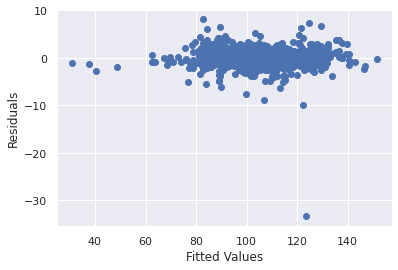

In [10]:
import statsmodels.api as sm

X = sm.add_constant(data.drop('trade_price', axis='columns'))
fullmod = sm.OLS(endog=data['trade_price'], exog=X).fit()

plt.scatter(fullmod.fittedvalues, fullmod.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

## 3. {-}

From the below normal probability plot, it is clear the residual distribution has heavier tail than normal, and the left tail seems to be heavier. Also, there is a clear outlier in the data. 

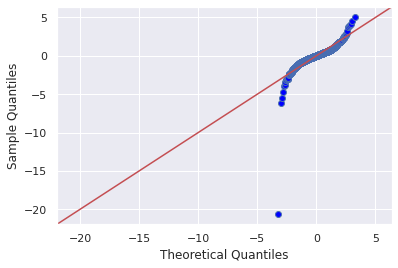

In [11]:
from statsmodels.graphics.gofplots import qqplot

qqplot(fullmod.resid, dist=norm, line='45', fit=True)
plt.show()

## 4., 5. {-}

Here is the stepwise variable selection procedure using AIC/PRESS. 

In [12]:
X.drop(['const'], axis='columns', inplace=True)

In [13]:
from statsmodels.stats import outliers_influence

def AIC(model):
    return model.aic

def PRESS(model):
    levs = outliers_influence.OLSInfluence(model).hat_matrix_diag
    return ((model.resid/(1 - levs))**2).sum()
    
def modelSelection(endog, exog, selectionMethod=AIC):
    '''
    Assuming no constant column in the input exog 
    '''
    chosen = []
    remaining = list(exog.columns.values)
    best = np.inf

    for i in range(len(X.columns)):
        idx_quantities = [(idx, selectionMethod(sm.OLS(endog, exog=sm.add_constant(exog[[feature] + chosen])).fit())) for idx, feature in enumerate(remaining)]
        idx, q = min(idx_quantities, key=lambda idx_q: idx_q[1])
        if q >= best:
            break
        best = q
        chosen.append(remaining[idx])
        remaining = remaining[:idx] + remaining[idx+1:]
    
    return chosen


chosenAIC = modelSelection(endog=data['trade_price'], exog=X, selectionMethod=AIC)
chosenPRESS = modelSelection(endog=data['trade_price'], exog=X, selectionMethod=PRESS)

chosenAIC, chosenPRESS

(['trade_price_last1',
  'curve_based_price',
  'trade_type_2',
  'trade_price_last7',
  'trade_type_3',
  'trade_price_last10',
  'trade_price_last4',
  'curve_based_price_last5',
  'trade_type_last1_3',
  'trade_type_last4_3',
  'trade_type_last4_2',
  'trade_type_last1_2',
  'trade_price_last9',
  'trade_type_last9_2',
  'curve_based_price_last1',
  'curve_based_price_last4',
  'curve_based_price_last3',
  'received_time_diff_last10',
  'trade_type_last5_3',
  'trade_price_last3',
  'is_callable_1',
  'reporting_delay'],
 ['trade_price_last1',
  'curve_based_price',
  'trade_type_2',
  'trade_price_last7',
  'trade_type_4',
  'trade_price_last10',
  'trade_type_last1_3',
  'curve_based_price_last5',
  'trade_price_last4',
  'trade_type_last4_3',
  'trade_type_last1_2',
  'trade_type_last4_2',
  'trade_size_last7',
  'is_callable_1',
  'trade_size',
  'received_time_diff_last10',
  'trade_price_last9',
  'trade_type_last9_2',
  'reporting_delay',
  'trade_type_last5_3',
  'received_t

The selection process is computationally intense. We copy and paste the results below. Using AIC, the procedure selected 22 features, while using PRESS, it selected 25. There are 18 common features selected by both methods. 

In [14]:
chosenAIC = ['trade_price_last1', 'curve_based_price', 'trade_type_2', 'trade_price_last7', 'trade_type_3', 'trade_price_last10', 'trade_price_last4', 'curve_based_price_last5', 'trade_type_last1_3', 'trade_type_last4_3', 'trade_type_last4_2', 'trade_type_last1_2', 'trade_price_last9', 'trade_type_last9_2', 'curve_based_price_last1', 'curve_based_price_last4', 'curve_based_price_last3', 'received_time_diff_last10', 'trade_type_last5_3', 'trade_price_last3', 'is_callable_1', 'reporting_delay']
chosenPRESS = ['trade_price_last1', 'curve_based_price', 'trade_type_2', 'trade_price_last7', 'trade_type_4', 'trade_price_last10', 'trade_type_last1_3', 'curve_based_price_last5', 'trade_price_last4', 'trade_type_last4_3', 'trade_type_last1_2', 'trade_type_last4_2', 'trade_size_last7', 'is_callable_1', 'trade_size', 'received_time_diff_last10', 'trade_price_last9', 'trade_type_last9_2', 'reporting_delay', 'trade_type_last5_3', 'received_time_diff_last8', 'trade_size_last4', 'trade_size_last5', 'trade_type_last1_4', 'trade_type_3'] 

len(chosenAIC), len (chosenPRESS), len(set(chosenAIC) & set(chosenPRESS))

(22, 25, 18)

Below are the summary of both models. They both have some features with coefficients very close to zero. If we take away those features, the resulting models will be almost identical. 

In [15]:
model = sm.OLS(endog=data['trade_price'], exog=sm.add_constant(X[chosenAIC])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            trade_price   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     3527.
Date:                Thu, 15 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:06:58   Log-Likelihood:                -3092.3
No. Observations:                1620   AIC:                             6231.
Df Residuals:                    1597   BIC:                             6355.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.2270      0.452      2.713      0.007       0.340       2.114
trade_price_last1             0.4340      0.028     15.456      0.000       0.379       0.489
curve_based_price             0.3929      0.038     10.296      0.000       0.318       0.468
trade_type_2                 -0.8080      0.100     -8.112      0.000      -1.003      -0.613
trade_price_last7             0.1129      0.023      4.843      0.000       0.067       0.159
trade_type_3                  0.8038      0.100      8.027      0.000       0.607       1.000
trade_price_last10            0.0376      0.026      1.422      0.155      -0.014       0.090
trade_price_last4             0.1033      0.030      3.392      0.001       0.044       0.163
curve_based_price_last5      -0.2031      0.050     -4.037      0.000      -0.302      -0.104
trade_type_last1_3           -0.2174      0.100     -2.169      0.030      -0.414      -0.021
trade_type_last4_3           -0.2073      0.103     -2.017      0.044      -0.409      -0.006
trade_type_last4_2            0.2007      0.104      1.929      0.054      -0.003       0.405
trade_type_last1_2            0.2293      0.106      2.157      0.031       0.021       0.438
trade_price_last9             0.0763      0.029      2.641      0.008       0.020       0.133
trade_type_last9_2            0.1874      0.100      1.883      0.060      -0.008       0.383
curve_based_price_last1      -0.0607      0.051     -1.180      0.238      -0.162       0.040
curve_based_price_last4       0.2077      0.074      2.795      0.005       0.062       0.354
curve_based_price_last3      -0.1591      0.066     -2.419      0.016      -0.288      -0.030
received_time_diff_last10 -3.692e-08   2.06e-08     -1.791      0.074   -7.74e-08    3.52e-09
trade_type_last5_3           -0.1440      0.088     -1.628      0.104      -0.317       0.029
trade_price_last3             0.0469      0.031      1.534      0.125      -0.013       0.107
is_callable_1                 0.1791      0.120      1.498      0.134      -0.055       0.413
reporting_delay            -1.75e-06   1.22e-06     -1.429      0.153   -4.15e-06    6.53e-07
==============================================================================
Omnibus:                     1930.311   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           907009.858
Skew:                          -5.538   Prob(JB):                         0.00
Kurtosis:                     118.389   Cond. No.                     3.10e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.1e+07. This might indicate t

In [16]:
model = sm.OLS(endog=data['trade_price'], exog=sm.add_constant(X[chosenPRESS])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            trade_price   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     3361.
Date:                Thu, 15 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:06:58   Log-Likelihood:                -3094.8
No. Observations:                1620   AIC:                             6238.
Df Residuals:                    1596   BIC:                             6367.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.7032      0.274      2.564      0.010       0.165       1.241
trade_price_last1             0.4291      0.026     16.782      0.000       0.379       0.479
curve_based_price             0.3540      0.028     12.554      0.000       0.299       0.409
trade_type_2                 -0.5763      0.114     -5.042      0.000      -0.800      -0.352
trade_price_last7             0.1113      0.023      4.748      0.000       0.065       0.157
trade_type_4                  0.2491      0.105      2.383      0.017       0.044       0.454
trade_price_last10            0.0486      0.026      1.853      0.064      -0.003       0.100
trade_type_last1_3            0.0175      0.107      0.163      0.871      -0.193       0.228
curve_based_price_last5      -0.1643      0.029     -5.654      0.000      -0.221      -0.107
trade_price_last4             0.1400      0.025      5.677      0.000       0.092       0.188
trade_type_last4_3           -0.2342      0.103     -2.272      0.023      -0.436      -0.032
trade_type_last1_2            0.4564      0.120      3.810      0.000       0.221       0.691
trade_type_last4_2            0.2174      0.106      2.060      0.040       0.010       0.424
trade_size_last7          -8.056e-08   5.48e-08     -1.469      0.142   -1.88e-07     2.7e-08
is_callable_1                 0.1951      0.120      1.631      0.103      -0.040       0.430
trade_size                 7.488e-08   5.71e-08      1.312      0.190   -3.71e-08    1.87e-07
received_time_diff_last10 -1.072e-07   6.32e-08     -1.697      0.090   -2.31e-07    1.67e-08
trade_price_last9             0.0709      0.029      2.463      0.014       0.014       0.127
trade_type_last9_2            0.1980      0.100      1.980      0.048       0.002       0.394
reporting_delay           -1.664e-06   1.23e-06     -1.355      0.176   -4.07e-06    7.44e-07
trade_type_last5_3           -0.1471      0.089     -1.655      0.098      -0.321       0.027
received_time_diff_last8   8.794e-08   7.06e-08      1.245      0.213   -5.06e-08    2.27e-07
trade_size_last4          -7.847e-08   5.67e-08     -1.385      0.166    -1.9e-07    3.26e-08
trade_size_last5           6.841e-08   6.04e-08      1.133      0.258   -5.01e-08    1.87e-07
trade_type_last1_4            0.2293      0.103      2.220      0.027       0.027       0.432
trade_type_3                  1.0304      0.109      9.426      0.000       0.816       1.245
==============================================================================
Omnibus:                     1943.345   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           923080.057
Skew:                          -5.607   Prob(JB):                         0.00
Kurtosis:                     119.402   C